In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import pandas as pd
import random
sns.set_context("notebook", font_scale=1.5)
def stability_traingle():
    from matplotlib.patches import Polygon
    ax=plt.gca()
    #ax.add_patch(Polygon([[2014, 9.855],[2064,18.540],[2064,9.855]],
    #                   closed=True, facecolor='g',alpha=0.05,label='Stability Triangle'))
    for indx,i in enumerate(np.arange(9.855,18.540)):
        if indx==0:
            ax.add_patch(Polygon([[2014,9.855],[2064,i+1],[2064,i]],
                       closed=True,facecolor=np.random.rand(3,1),
                             edgecolor='w',lw=3,alpha=0.50,label='One Wedge'))
        else:
            ax.add_patch(Polygon([[2014,9.855],[2064,i+1],[2064,i]],
                       closed=True,facecolor=np.random.rand(3,1),
                             edgecolor='w',lw=3,alpha=0.50))
    return

# World data - Preliminaries


## $CO_2$  projection

2064 projection is 18.540322
Gap is 8.685322


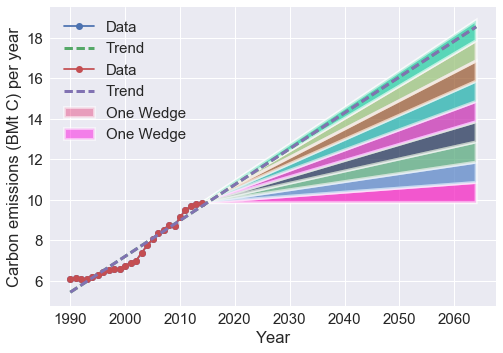

In [4]:
# read data
df = pd.read_csv('global_co2.csv')
df = df[df['Year'] >= 1990]
df['Carbon Emissions']=df['Carbon Emissions']/1e3
plt.plot(df['Year'],df['Carbon Emissions'],'o-',label='Data')
# linear fit of data
def linear(x, a, b):
    return a * x + b
years = np.arange(np.min(df['Year']),2065)
popt, pcov = curve_fit(linear, df['Year'],df['Carbon Emissions'])
trend = linear(years,*popt)
plt.plot(years,trend,'--',lw=3,label='Trend')
# triangle of stability
stability_traingle()
print('2064 projection is {:f}'.format(linear(2064,*popt)))
print('Gap is {:f}'.format(linear(2064,*popt)-9.855))
# plot stuff
plt.xlabel('Year')
plt.ylabel('Carbon emissions (BMt C) per year')
plt.legend(loc='best')
plt.savefig('c_emissions.png',dpi=300)
plt.show()

## GWP projection

GWP 2065 is 404307.566009
Ratio of 2014 to 2065 is 5.138870


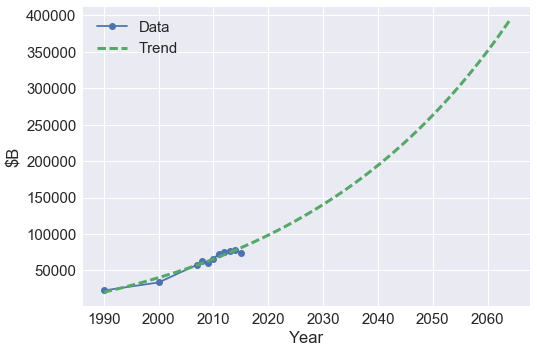

In [5]:
# historical data
df = pd.read_csv('GWP.csv')
plt.plot(df['Year'],df['GWP'],'o-',label='Data')
# exp fit of data
def exponential(x, a, b,c):
    x_norm=x-1990
    #c = 22545
    return a * np.exp(x_norm*b) + c
years = np.arange(np.min(df['Year']),2065)
popt, pcov = curve_fit(exponential, df['Year'],df['GWP'])
GWP_trend = exponential(years,*popt)
plt.plot(years,GWP_trend,'--',lw=3,label='Trend')
# stats
ratio = exponential(2065,*popt)/np.max(df['GWP'])
print('GWP 2065 is {:f}'.format(exponential(2065,*popt)))
print('Ratio of 2014 to 2065 is {:f}'.format(ratio))
#plots
plt.xlabel('Year')
plt.ylabel('$B')
plt.legend(loc='best')
plt.savefig('GWP.png',dpi=300)
plt.show()

## Statistics calculators

In [15]:
def linear_capacity_projection(init_cap,cap_factor, energy_req):
    max_cap = energy_req/(8760*cap_factor) # capacity to meet requirements based on cap factor, in GW
    ratio_cap = max_cap/init_cap
    print('* From an initial capacity of {:.2f} GW'.format(init_cap/1e6))
    print('* To a 50 year capacity of {:.2f} GW ({:.2f} GW more)'.format((max_cap+init_cap)/1e6,max_cap/1e6))
    print('* Which means {:.2f} x more capacity will be built.'.format(ratio_cap))
    years= np.arange(0,51)
    lin_curve = (years/50.0)
    cap = lin_curve*max_cap + init_cap
    growth_rate = (np.diff(cap)/cap[:-1])*100
    print('\t * at 1th year the capacity is {:.2f} GW ({:.2f} % more from last year)'.format(cap[1]/1e6,growth_rate[0]))
    print('\t * at 50th year the capacity is {:.2f} GW ({:.2f} % more from last year)'.format(cap[-1]/1e6,growth_rate[-1]))
    return cap[1:], growth_rate[1:]

def linear_cost_projection(LCOE,energy_req,GWP):
    cost_energy = energy_req/LCOE
    years= np.arange(1,51)
    lin_curve = (years/50.0)
    cost_per_year = lin_curve*cost_energy
    GWP_fraction = (cost_per_year/GWP)*100
    print('* With linear growth in capacity of {:.2f} %'.format(1/50.0*100))
    cost_demand= (GWP_fraction[0]/100.0*GWP[0])/1e9
    print('\t * at 1th year this is {:.2f}% of GWP, or ${:.2f} B'.format(GWP_fraction[0],cost_demand))
    cost_demand= (GWP_fraction[-1]/100*GWP[-1])/1e9
    print('\t * at 50th year this is {:.2f}% of GWP, or ${:.2f} B'.format(GWP_fraction[-1],cost_demand))

    return GWP_fraction


def exp_capacity_projection(LCOE,GWP,GWP_fraction):

    energy_gen = GWP*(GWP_fraction/100)*LCOE
    
    cap = energy_gen/(8760*cap_factor) + init_cap
    growth_rate = (np.diff(cap)/cap[:-1])*100
    print('* With exp growth in capacity in 50 years')
    print('\t * at 1th year the capacity is {:.2f} GW ({:.2f} % more from last year)'.format(cap[1]/1e6,growth_rate[0]))
    print('\t * at 50th year the capacity is {:.2f} GW ({:.2f} % more from last year)'.format(cap[-1]/1e6,growth_rate[-1]))
    return cap, growth_rate

def exp_cost_projection(LCOE,energy_req,GWP):
    cost_energy = energy_req/LCOE
    GWP_fraction = (np.ones(len(GWP))* cost_energy/GWP[-1])*100
    
    print('* With fixed GWP investment in 50 years')
    cost_demand= (GWP_fraction[0]/100.0*GWP[0])/1e9
    print('\t * at 1th year this is {:.2f}% of GWP, or ${:.2f} B'.format(GWP_fraction[0],cost_demand))
    cost_demand= (GWP_fraction[-1]/100*GWP[-1])/1e9
    print('\t * at 50th year this is {:.2f}% of GWP, or ${:.2f} B'.format(GWP_fraction[-1],cost_demand))

    return GWP_fraction

To save results

In [16]:
from collections import OrderedDict
GWP_frac=OrderedDict()
max_cap=OrderedDict()
growth_rate=OrderedDict()
color_style=OrderedDict()
line_style=OrderedDict()
GWP = GWP_trend[-50:]*1e9

# Solar

In [17]:
label='Solar'
color_style[label+' (lin g)']='r'
color_style[label+' (f GWP)']='r'
line_style[label+' (lin g)']='-'
line_style[label+' (f GWP)']=':'

LCOE=55/1e3 # $ / kWh (MWh to KWh)
energy_req = 4491 *1e9 # TWh to KWh
cap_factor = 0.20 # capacity factor
init_cap = 229 *1e6 # GW to KW
print('== {} results =='.format(label))
print('* LCOE of ${:.4f} per KWh with capacity factor of {:0.3f}'.format(LCOE,cap_factor))
max_cap[label+' (lin g)'],growth_rate[label+' (lin g)'] = linear_capacity_projection(init_cap,cap_factor, energy_req)
GWP_frac[label+' (lin g)']=linear_cost_projection(LCOE,energy_req,GWP)
GWP_frac[label+' (f GWP)']= exp_cost_projection(LCOE,energy_req,GWP)
max_cap[label+' (f GWP)'],growth_rate[label+' (f GWP)'] = exp_capacity_projection(LCOE,GWP,GWP_frac[label+' (f GWP)'])


== Solar results ==
* LCOE of $0.0550 per KWh with capacity factor of 0.200
* From an initial capacity of 229.00 GW
* To a 50 year capacity of 2792.36 GW (2563.36 GW more)
* Which means 11.19 x more capacity will be built.
	 * at 1th year the capacity is 280.27 GW (22.39 % more from last year)
	 * at 50th year the capacity is 2792.36 GW (1.87 % more from last year)
* With linear growth in capacity of 2.00 %
	 * at 1th year this is 2.01% of GWP, or $1633.09 B
	 * at 50th year this is 20.77% of GWP, or $81654.55 B
* With fixed GWP investment in 50 years
	 * at 1th year this is 20.77% of GWP, or $16847.99 B
	 * at 50th year this is 20.77% of GWP, or $81654.55 B
* With exp growth in capacity in 50 years
	 * at 1th year the capacity is 779.49 GW (2.85 % more from last year)
	 * at 50th year the capacity is 2792.36 GW (2.60 % more from last year)


# Wind

In [9]:
label='Wind'
color_style[label+' (lin g)']='b'
color_style[label+' (f GWP)']='b'
line_style[label+' (lin g)']='-'
line_style[label+' (f GWP)']=':'
LCOE=48/1e3 # $ / kWh (MWh to KWh)
energy_req = 4491 *1e9 # TWh to KWh
cap_factor = 0.20 # capacity factor
init_cap = 432 *1e6 # GW to KW
print('== {} results =='.format(label))
print('* LCOE of ${:.4f} per KWh with capacity factor of {:0.3f}'.format(LCOE,cap_factor))
max_cap[label+' (lin g)'],growth_rate[label+' (lin g)'] = linear_capacity_projection(init_cap,cap_factor, energy_req)
GWP_frac[label+' (lin g)']=linear_cost_projection(LCOE,energy_req,GWP)
GWP_frac[label+' (f GWP)']= exp_cost_projection(LCOE,energy_req,GWP)
max_cap[label+' (f GWP)'],growth_rate[label+' (f GWP)'] = exp_capacity_projection(LCOE,GWP,GWP_frac[label+' (f GWP)'])


== Wind results ==
* LCOE of $0.0480 per KWh with capacity factor of 0.200
* From an initial capacity of 432.00 GW
* To a 50 year capacity of 2995.36 GW (2563.36 GW more)
* Which means 5.93 x more capacity will be built.
	 * at 1th year the capacity is 483.27 GW (11.87 % more from last year)
	 * at 50th year the capacity is 2995.36 GW (1.74 % more from last year)
* With linear growth in capacity of 2.00 %
	 * at 1th year this is 2.31% of GWP, or $1871.25 B
	 * at 50th year this is 23.80% of GWP, or $93562.50 B
* With fixed GWP investment in 50 years
	 * at 1th year this is 23.80% of GWP, or $19304.98 B
	 * at 50th year this is 23.80% of GWP, or $93562.50 B
* With exp growth in capacity in 50 years
	 * at 1th year the capacity is 982.49 GW (2.25 % more from last year)
	 * at 50th year the capacity is 2995.36 GW (2.42 % more from last year)


# Nuclear

In [10]:
label='Nuclear'
color_style[label+' (lin g)']='g'
color_style[label+' (f GWP)']='g'
line_style[label+' (lin g)']='-'
line_style[label+' (f GWP)']=':'
LCOE=116.5/1e3 # $ / kWh (MWh to KWh)
energy_req = 4491 *1e9 # TWh to KWh
cap_factor = 0.90 # capacity factor
init_cap = 392 *1e6 # GW to KW
print('== {} results =='.format(label))
print('* LCOE of ${:.4f} per KWh with capacity factor of {:0.3f}'.format(LCOE,cap_factor))
max_cap[label+' (lin g)'],growth_rate[label+' (lin g)'] = linear_capacity_projection(init_cap,cap_factor, energy_req)
GWP_frac[label+' (lin g)']=linear_cost_projection(LCOE,energy_req,GWP)
GWP_frac[label+' (f GWP)']= exp_cost_projection(LCOE,energy_req,GWP)
max_cap[label+' (f GWP)'],growth_rate[label+' (f GWP)'] = exp_capacity_projection(LCOE,GWP,GWP_frac[label+' (f GWP)'])


== Nuclear results ==
* LCOE of $0.1165 per KWh with capacity factor of 0.900
* From an initial capacity of 392.00 GW
* To a 50 year capacity of 961.63 GW (569.63 GW more)
* Which means 1.45 x more capacity will be built.
	 * at 1th year the capacity is 403.39 GW (2.91 % more from last year)
	 * at 50th year the capacity is 961.63 GW (1.20 % more from last year)
* With linear growth in capacity of 2.00 %
	 * at 1th year this is 0.95% of GWP, or $770.99 B
	 * at 50th year this is 9.80% of GWP, or $38549.36 B
* With fixed GWP investment in 50 years
	 * at 1th year this is 9.80% of GWP, or $7953.98 B
	 * at 50th year this is 9.80% of GWP, or $38549.36 B
* With exp growth in capacity in 50 years
	 * at 1th year the capacity is 514.33 GW (0.94 % more from last year)
	 * at 50th year the capacity is 961.63 GW (1.66 % more from last year)


# Global capacity

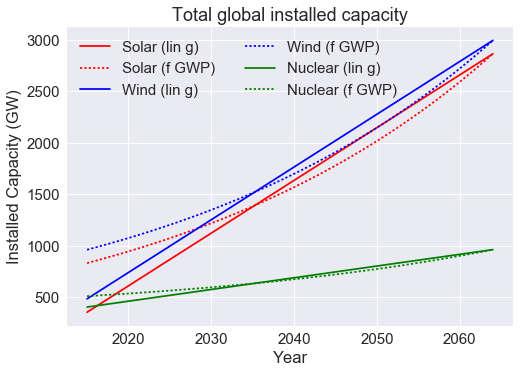

In [11]:
init_year=2014
years =np.arange(init_year+1,init_year+51)
for key,val in max_cap.items():
    plt.plot(years,val/1e6,label=key,ls=line_style[key],c=color_style[key])

plt.title('Total global installed capacity')
plt.legend(loc='best',ncol=2)
plt.xlabel('Year')
plt.ylabel('Installed Capacity (GW)')
plt.savefig('cap_installed.png',dpi=300)
plt.show()

# Annual Growth rate

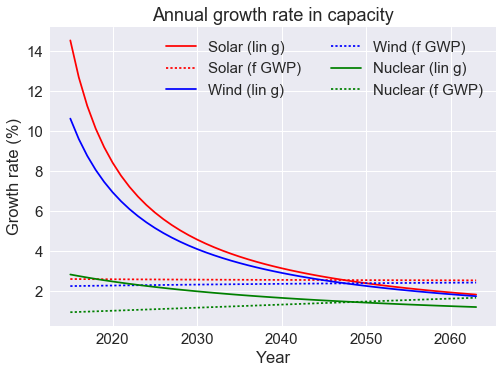

In [12]:
init_year=2014
years =np.arange(init_year+1,init_year+50)
for key,val in growth_rate.items():
    plt.plot(years,val,label=key,ls=line_style[key],c=color_style[key])

plt.title('Annual growth rate in capacity')
plt.legend(loc='best',ncol=2)
plt.xlabel('Year')
plt.ylabel('Growth rate (%)')
plt.savefig('cap_growth.png',dpi=300)
plt.show()

# GWP cost

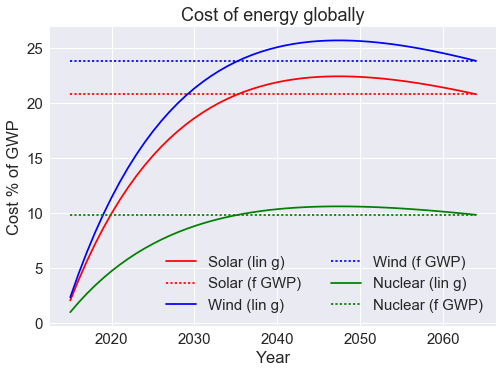

In [13]:
init_year=2015
years =np.arange(init_year,init_year+50)
for key,val in GWP_frac.items():
    plt.plot(years,val,label=key,ls=line_style[key],c=color_style[key])

plt.title('Cost of energy globally')
plt.legend(loc='best',ncol=2)
plt.xlabel('Year')
plt.ylabel('Cost % of GWP')
plt.savefig('GWP_cost.png',dpi=300)
plt.show()